In [1]:
from trainer.trainer import CWPTT
import matplotlib.pyplot as plt
n_debris = 3 # number of debris
trainer = CWPTT(n_debris, "cuda") # `planTrackTrainer` instance
trainer.agent.load(f"../model/planTrack{n_debris}.ptd")

In [ ]:
ll = trainer.trainTracker(1200,) # train tracker solely, mode-based
trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
plt.plot(ll) # loss
plt.show()

In [ ]:
al, cl, tr = trainer.trainPlanner(episode=1000, epoch=10) # train planner and critic, mode-free
trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
plt.plot(tr) # total reward
plt.show()

In [8]:
results = trainer.trainUnity(3600, epoch=1, batch_size=128) # train all model together, to be completed

Output()

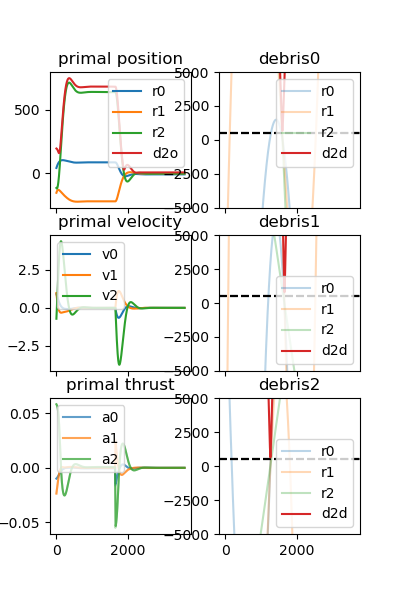

In [2]:
from plotting.analyze import *
%matplotlib widget
horizon = 3600
d, stage = trainer.test(horizon, "static") # test agent
plt.close('all')
n_debris = trainer.mainProp.n_debris
fig, _ = historyFile(d, agent=None, stage=stage, n_debris=n_debris,) # visualization

In [5]:
x = d["states"][:,:6*(n_debris+1)]

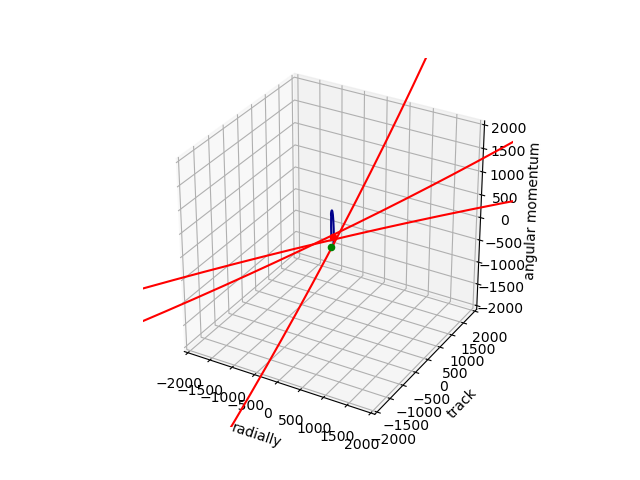

In [8]:
from plotting.trajplot import mulDeTrajPlot
plt.close('all')
ax, objs = mulDeTrajPlot(x)
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from plotting import trajplot
import math

def foo(x:np.ndarray,
        box_lim=2000,
        step=10,
        interval=5
        ):
    fig = plt.figure()
    ax = fig.add_axes(rect=[0, 0, 1, 1],
                      projection='3d',
                      xlim=(-box_lim, box_lim),
                      ylim=(-box_lim, box_lim),
                      zlim=(-box_lim, box_lim)
                     )
    ax.set_xlabel("radially")
    ax.set_ylabel("track")
    ax.set_zlabel("angular momentum")
    ax.set_aspect("equal")
    total = x.shape[0]
    x = x.reshape([total, -1, 6])

    n_frame = math.ceil(total/step)

    ax, objs = trajplot.mulDeTrajPlot(x, ax=ax, cur_pos=True)
    trajs = objs["trajs"]
    curs = objs["curs"]
    n_obj = len(trajs)

    colors = ["blue"] + ["red" for _ in range(n_obj-1)]

    def animate(frame_number):
        n = frame_number*step
        for i in range(n_obj):
            trajs[i].remove()
            trajs[i] = ax.plot3D(x[:n,i,0],x[:n,i,1],x[:n,i,2], color=colors[i])[0]
            curs[i].remove()
            curs[i] = ax.scatter3D(x[n,i,0],x[n,i,1],x[n,i,2], color=colors[i])
            

    ani = animation.FuncAnimation(fig, animate, frames=n_frame, interval=interval)

    return ani

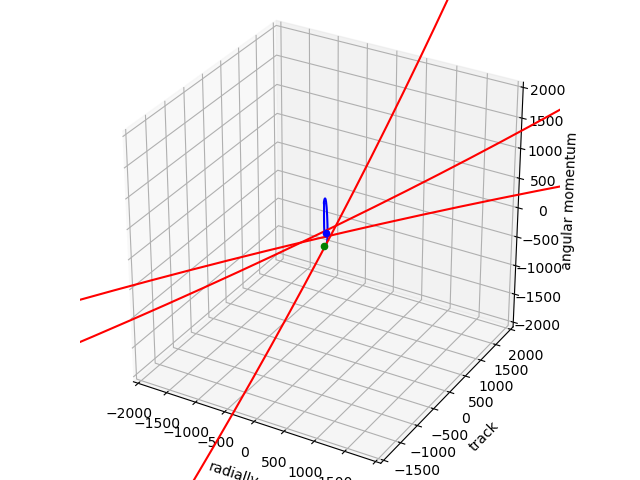

In [20]:
ani = foo(x, interval=50)
ani.save('animation.gif', writer='ffmpeg')

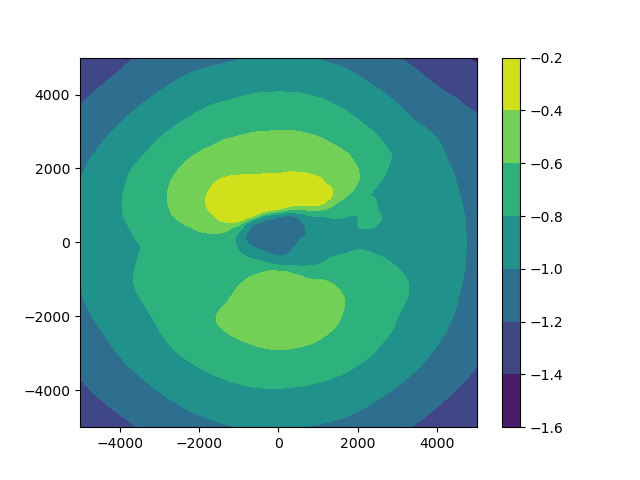

In [322]:
import numpy as np
from plotting import analyze
import torch
s = trainer.mainProp.randomInitStates(1)
o = trainer.mainProp.getObss(s)
o_a = np.hstack((o.flatten(), np.zeros(trainer.agent.control_dim)))

n_f = trainer.agent.critic.n_feature
axis = np.array([0,2])
axis.sort()
dims = n_f-(3-axis)
o_a_ = np.delete(o_a, dims)

plt.close("all")
analyze.criticContour(trainer.agent, span=(-5000,5000), dims=dims, step=101, singles=o_a_) # contour plot of critic in selected dims

target = trainer.agent.planner(torch.from_numpy(o).float().to(trainer.agent.device))
target = target.detach().cpu().numpy().flatten()
_ = plt.scatter(target[axis[0]], target[axis[1]], c="r") # planner's output